# ONNX graph, single or double floats

The notebook shows discrepencies obtained by using double floats instead of single float in two cases. The second one involves [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Simple case of a linear regression

A linear regression is simply a matrix multiplication followed by an addition: $Y=AX+B$. Let's train one with [scikit-learn](https://scikit-learn.org/stable/).

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
data = load_boston()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression()

In [3]:
clr.score(X_test, y_test)

0.7305965839248935

In [4]:
clr.coef_

array([-1.15896254e-01,  3.85174778e-02,  1.59315996e-02,  3.22074735e+00,
       -1.85418374e+01,  3.21813935e+00,  1.12610939e-02, -1.32043742e+00,
        3.67002299e-01, -1.41101521e-02, -1.10152072e+00,  6.17018918e-03,
       -5.71549389e-01])

In [5]:
clr.intercept_

43.97633987084284

Let's predict with *scikit-learn* and *python*.

In [6]:
ypred = clr.predict(X_test)
ypred[:5]

array([17.72795971, 18.69312745, 21.13760633, 16.65607505, 22.47115623])

In [7]:
py_pred = X_test @ clr.coef_ + clr.intercept_
py_pred[:5]

array([17.72795971, 18.69312745, 21.13760633, 16.65607505, 22.47115623])

In [8]:
clr.coef_.dtype, clr.intercept_.dtype

(dtype('float64'), dtype('float64'))

## With ONNX

With *ONNX*, we would write this operation as follows... We still need to convert everything into single floats = float32.

In [9]:
%load_ext mlprodict

In [10]:
from skl2onnx.algebra.onnx_ops import OnnxMatMul, OnnxAdd
import numpy

onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float32), op_version=12),
                   numpy.array([clr.intercept_], dtype=numpy.float32),
                   output_names=['Y'], op_version=12)
onnx_model32 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float32)})

# add -l 1 if nothing shows up
%onnxview onnx_model32

The next line uses a python runtime to compute the prediction.

In [11]:
from mlprodict.onnxrt import OnnxInference
oinf = OnnxInference(onnx_model32, inplace=False)
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([17.727959, 18.693125, 21.137608, 16.656076, 22.471157],
      dtype=float32)

And here is the same with [onnxruntime](https://github.com/microsoft/onnxruntime)...

In [12]:
from mlprodict.tools.asv_options_helper import get_ir_version_from_onnx
# line needed when onnx is more recent than onnxruntime
onnx_model32.ir_version = get_ir_version_from_onnx()
oinf = OnnxInference(onnx_model32, runtime="onnxruntime1")
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([17.727959, 18.693125, 21.137608, 16.656076, 22.471157],
      dtype=float32)

## With double instead of single float

[ONNX](https://onnx.ai/) was originally designed for deep learning which usually uses floats but it does not mean cannot be used. Every number is converted into double floats.

In [13]:
onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float64), op_version=12),
                   numpy.array([clr.intercept_], dtype=numpy.float64),
                   output_names=['Y'], op_version=12)
onnx_model64 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float64)})

And now the *python* runtime...

In [14]:
oinf = OnnxInference(onnx_model64)
ort_pred = oinf.run({'X': X_test})['Y']
ort_pred[:5]

array([17.72795971, 18.69312745, 21.13760633, 16.65607505, 22.47115623])

And the *onnxruntime* version of it.

In [15]:
oinf = OnnxInference(onnx_model64, runtime="onnxruntime1")
ort_pred = oinf.run({'X': X_test.astype(numpy.float64)})['Y']
ort_pred[:5]

array([17.72795971, 18.69312745, 21.13760633, 16.65607505, 22.47115623])

## And now the GaussianProcessRegressor

This shows a case

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
gau = GaussianProcessRegressor(alpha=10, kernel=DotProduct())
gau.fit(X_train, y_train)

GaussianProcessRegressor(alpha=10, kernel=DotProduct(sigma_0=1))

In [17]:
from mlprodict.onnx_conv import to_onnx
onnxgau32 = to_onnx(gau, X_train.astype(numpy.float32))
oinf32 = OnnxInference(onnxgau32, runtime="python", inplace=False)
ort_pred32 = oinf32.run({'X': X_test.astype(numpy.float32)})['GPmean']
numpy.squeeze(ort_pred32)[:25]

array([17.25    , 19.59375 , 21.34375 , 17.625   , 21.953125, 30.      ,
       18.875   , 19.625   ,  9.9375  , 20.5     , -0.53125 , 16.375   ,
       16.8125  , 20.6875  , 27.65625 , 16.375   , 39.0625  , 36.0625  ,
       40.71875 , 21.53125 , 29.875   , 30.34375 , 23.53125 , 15.25    ,
       35.5     ], dtype=float32)

In [18]:
onnxgau64 = to_onnx(gau, X_train.astype(numpy.float64))
oinf64 = OnnxInference(onnxgau64, runtime="python", inplace=False)
ort_pred64 = oinf64.run({'X': X_test.astype(numpy.float64)})['GPmean']
numpy.squeeze(ort_pred64)[:25]

array([17.22940605, 19.07756253, 21.000277  , 17.33514034, 22.37701168,
       30.10867125, 18.72937468, 19.2220674 ,  9.74660609, 20.3440565 ,
       -0.1354653 , 16.47852265, 17.12332707, 21.04137646, 27.21477015,
       16.2668399 , 39.31065954, 35.99032274, 40.53761676, 21.51909954,
       29.49016665, 30.22944875, 23.58969906, 14.56499415, 35.28957228])

The differences between the predictions for single floats and double floats...

In [19]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - ort_pred64)))[-5:]

array([0.51618747, 0.54317928, 0.61256575, 0.63292898, 0.68500585])

Who's right or wrong... The differences between the predictions with the original model...

In [20]:
pred = gau.predict(X_test.astype(numpy.float64))

In [21]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - pred)))[-5:]

array([0.51618747, 0.54317928, 0.61256575, 0.63292898, 0.68500585])

In [22]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred64 - pred)))[-5:]

array([0., 0., 0., 0., 0.])

Double predictions clearly wins.

In [23]:
# add -l 1 if nothing shows up
%onnxview onnxgau64

## Saves...

Let's keep track of it.

In [24]:
with open("gpr_dot_product_boston_32.onnx", "wb") as f:
    f.write(onnxgau32.SerializePartialToString())
from IPython.display import FileLink
FileLink('gpr_dot_product_boston_32.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_32.onnx

In [25]:
with open("gpr_dot_product_boston_64.onnx", "wb") as f:
    f.write(onnxgau64.SerializePartialToString())
FileLink('gpr_dot_product_boston_64.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_64.onnx

## Side by side

We may wonder where the discrepencies start. But for that, we need to do a side by side.

In [26]:
from mlprodict.onnxrt.validate.side_by_side import side_by_side_by_values
sbs = side_by_side_by_values([(oinf32, {'X': X_test.astype(numpy.float32)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])

from pandas import DataFrame
df = DataFrame(sbs)
# dfd = df.drop(['value[0]', 'value[1]', 'value[2]'], axis=1).copy()
df

,metric,step,v[0],v[1],cmp,name,value[0],shape[0],value[1],shape[1]
0,nb_results,-1,9,9.000000e+00,OK,NaN,NaN,NaN,NaN,NaN
1,abs-diff,0,0,4.902064e-08,OK,X,"[[0.21977, 0.0, 6.91, 0.0, 0.448, 5.602, 62.0,...","(127, 13)","[[0.21977, 0.0, 6.91, 0.0, 0.448, 5.602, 62.0,...","(127, 13)"
2,abs-diff,1,0,2.402577e-02,e<0.1,GPmean,"[[17.25, 19.59375, 21.34375, 17.625, 21.953125...","(1, 127)","[[17.229406048412784, 19.077562531849253, 21.0...","(1, 127)"
3,abs-diff,2,0,5.553783e-08,OK,kgpd_MatMulcst,"[[16.8118, 0.26169, 7.67202, 0.57529, 1.13081,...","(13, 379)","[[16.8118, 0.26169, 7.67202, 0.57529, 1.13081,...","(13, 379)"
4,abs-diff,3,0,2.421959e-08,OK,kgpd_Addcst,[1117.718],"(1,)",[1117.718044648797],"(1,)"
5,abs-diff,4,0,5.206948e-08,OK,gpr_MatMulcst,"[-0.040681414, -0.37079695, -0.7959402, 0.4380...","(379,)","[-0.04068141268069173, -0.37079693473728526, -...","(379,)"
6,abs-diff,5,0,0.000000e+00,OK,gpr_Addcst,[[0.0]],"(1, 1)",[[0.0]],"(1, 1)"
7,abs-diff,6,0,1.856291e-07,OK,kgpd_Y0,"[[321007.53, 235496.9, 319374.4, 230849.73, 22...","(127, 379)","[[321007.55279690475, 235496.9156560601, 31937...","(127, 379)"
8,abs-diff,7,0,1.856291e-07,OK,kgpd_C0,"[[321007.53, 235496.9, 319374.4, 230849.73, 22...","(127, 379)","[[321007.55279690475, 235496.9156560601, 31937...","(127, 379)"
9,abs-diff,8,0,2.402577e-02,e<0.1,gpr_Y0,"[17.25, 19.59375, 21.34375, 17.625, 21.953125,...","(127,)","[17.229406048412784, 19.077562531849253, 21.00...","(127,)"


The differences really starts for output ``'O0'`` after the matrix multiplication. This matrix melts different number with very different order of magnitudes and that alone explains the discrepencies with doubles and floats on that particular model.

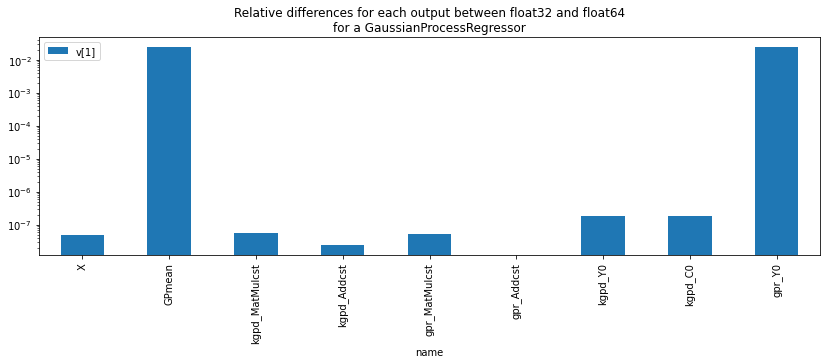

In [27]:
%matplotlib inline
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float32 and "
             "float64\nfor a GaussianProcessRegressor");

Before going further, let's check how sensitive the trained model is about converting double into floats.

In [28]:
pg1 = gau.predict(X_test)
pg2 = gau.predict(X_test.astype(numpy.float32).astype(numpy.float64))
numpy.sort(numpy.sort(numpy.squeeze(pg1 - pg2)))[-5:]

array([1.53295696e-06, 1.60621130e-06, 1.65373785e-06, 1.66549580e-06,
       2.36724736e-06])

Having float or double inputs should not matter. We confirm that with the model converted into ONNX.

In [29]:
p1 = oinf64.run({'X': X_test})['GPmean']
p2 = oinf64.run({'X': X_test.astype(numpy.float32).astype(numpy.float64)})['GPmean']
numpy.sort(numpy.sort(numpy.squeeze(p1 - p2)))[-5:]

array([1.53295696e-06, 1.60621130e-06, 1.65373785e-06, 1.66549580e-06,
       2.36724736e-06])

Last verification.

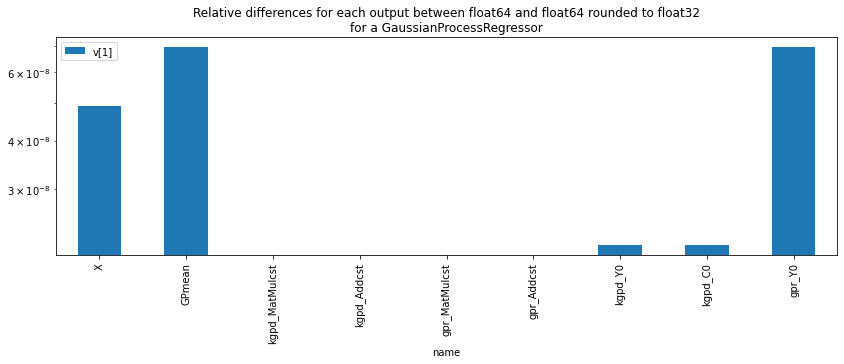

In [30]:
sbs = side_by_side_by_values([(oinf64, {'X': X_test.astype(numpy.float32).astype(numpy.float64)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])
df = DataFrame(sbs)
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float64 and float64 rounded to float32"
             "\nfor a GaussianProcessRegressor");